In [3]:
import os

import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)
import warnings
warnings.filterwarnings('ignore')

##  developing model families using visual diagnostics and numeric summaries
If you run the user interface code which states input and output format as below, it creates specific model, data, plot (two `.stan`, two `.nc files, multiple plots) in three folders. With minimal number of clicks, your model quality can be inspected. This aim of this vignette is to inspect how given the two outputs (model and data) can be analyzed for your next move.

keyword: simulation-based calibration, pair plots, divergence, InferenceData

We load produced data for plotting. Please refer to the end of this document for model (stan code) and data structure which is Stanify's main contribution, but not the scope here.

`data2draws` have four groups: `posterior`, `prior_predictive`, `log_likelihood`, `samp_stats`, `observed_data`. First click the arrow below to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `posterior` group, observed vector (adding measurement noise on target simulated vector posterior) for `osberved_data` group, loglikelihood of each posterior sample for `log_likelihood`, lp, acceptance_rate, tree_depth, energy (HMC alg.parameters) `sample_stats_prior` group)

The PPC (prior/poseterior predictive check) plot is a standard way for Bayesian checking. It serves complementary role with simulation-based calibration (SBC). Two checks happen in different space: PPC in observation space as time series, SBC in parameter space as rank comparison between the ground truth and retrieved estimated samples. From the plot, posterior predictive's negative values is the most problematic which was expected as the currrent version uses normal likelihood. Changing this to lognoraml or negative binomial can solve this problem, but lognormal has thicker tail creating difficult posterior geometry and negative binomial need transformation to integer value which is known to be not accurate.

new plot that compares against time is needed for dynamic models. posterior predictive is quite different from general bayse models.

array([<AxesSubplot: xlabel='production_rate_stocked_obs / production_rate_stocked_obs_post'>,
       <AxesSubplot: xlabel='production_start_rate_stocked_obs / production_start_rate_stocked_obs_post'>],
      dtype=object)

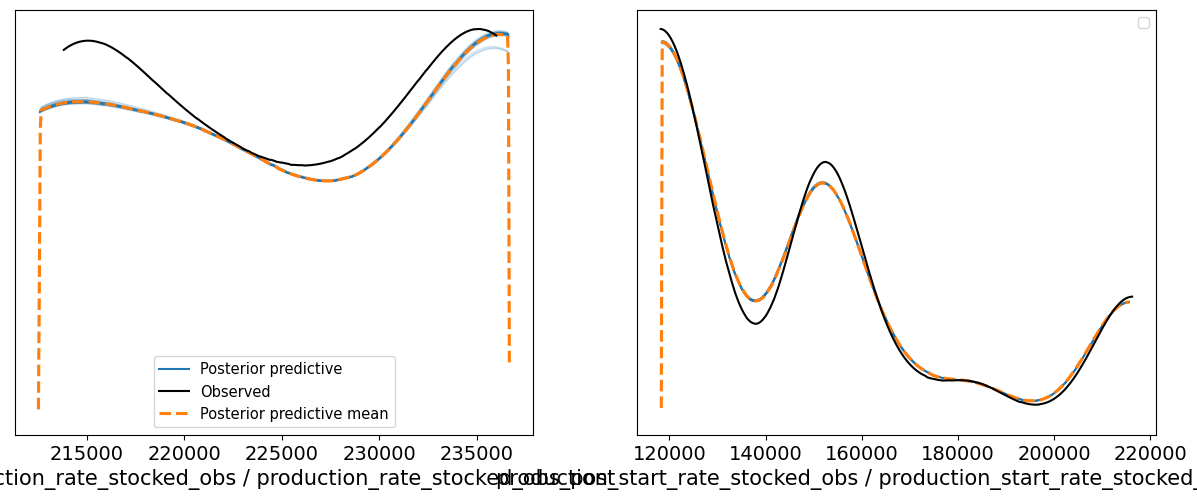

In [11]:
az.plot_ppc(sbc, data_pairs = {'production_rate_stocked_obs':'production_rate_stocked_obs_post', 'production_start_rate_stocked_obs':'production_start_rate_stocked_obs_post'})

# Appendix

## model

In [20]:
print(CmdStanModel(stan_file=f"stan_files/{modelname}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{modelname}/data2draws.stan").code())

functions{
  #include functions.stan
}

data{
    int <lower=0> S;  // # of draws from prior 
    int <lower=0> M;  // # of draws from posterior (# of chains * # of draws from each chain)
    int <lower=0> N;  // # of observation
    int <lower=0> Q;  // # of target_simulated_stock and obs_vectors 
    int <lower=0> R;  // # of subgroups for hierarchical Bayes 
    real <lower=0> time_step;
    array[N] real integration_times;
    vector[10] customer_order_rate;
    vector[10] process_noise_uniform_driving;
    real process_noise_scale;
}

transformed data {
    real initial_time = 0.0;

    // Initial ODE values
    real backlog__init = dataFunc__customer_order_rate(0, time_step) * 2;
    real expected_order_rate__init = dataFunc__customer_order_rate(0, time_step);
    real inventory__init = 2 + 2 * dataFunc__customer_order_rate(0, time_step);
    real process_noise__init = 0;
    real production_rate_stocked__init = 8 * fmax(0, dataFunc__customer_order_rate(0, time_step) + (2 + 2 * d